# TRABALHO 6: Homografia e RANSAC
### Discente: Kawan Oliveira

## 1. Extrai pontos e descritores SIFT nas duas imagens
## 2. Realize o casamento (matching) entre os descritores de ambas as imagens

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Carregar as imagens
img1 = cv2.imread('001.jpg', cv2.IMREAD_GRAYSCALE)  # Imagem 1
img2 = cv2.imread('002.jpg', cv2.IMREAD_GRAYSCALE)  # Imagem 2

# Criar o objeto SIFT
sift = cv2.SIFT_create()

# Detecção de pontos de interesse e cálculo dos descritores
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Criar o objeto BFMatcher (Brute-Force Matcher)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Realizar o casamento de descritores
matches = bf.match(des1, des2)

# Ordenar os matchs pelos mais próximos (menor distância)
matches = sorted(matches, key=lambda x: x.distance)

# Visualizar os primeiros 10 matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Exibir as imagens
plt.figure(figsize=(10, 5))
plt.imshow(img_matches)
plt.title('Casamento de Descritores SIFT')
plt.show()


Neste código, estou utilizando a técnica SIFT (Scale-Invariant Feature Transform) para detectar e descrever pontos de interesse em duas imagens e realizar o casamento entre os descritores desses pontos usando o BFMatcher (Brute-Force Matcher), que eu descobri vasculhando que existia na biblioteca da OpenCV.
Resumo:
O código carrega duas imagens em escala de cinza; Usando SIFT, detecta pontos de interesse nas duas imagens e calcula seus descritores. Após isso, o algoritmo BFMatcher é utilizado para encontrar correspondências entre os descritores de ambas as imagens. Por fim, o código desenha as correspondências (linhas) entre os pontos-chave nas imagens e exibe uma imagem com as primeiras 10 correspondências mais próximas (menor distância).

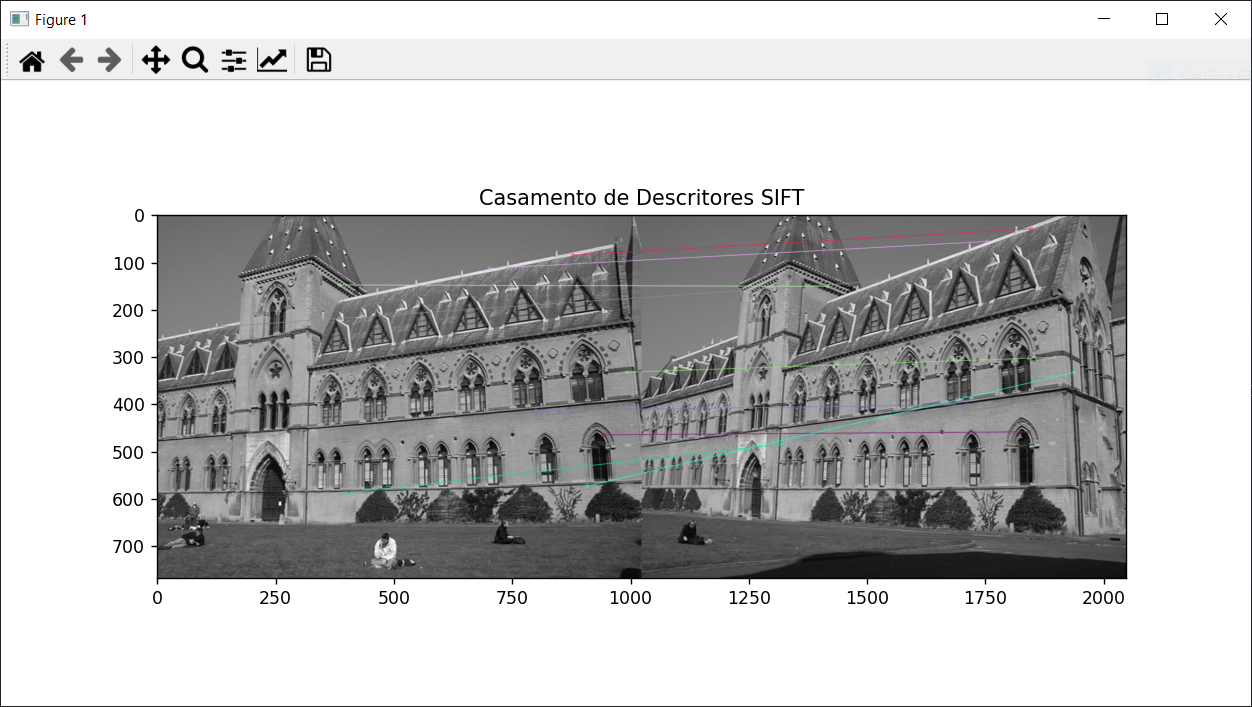

## 3. Utilize RANSAC para estimar uma homografia entre o plano presente na imagem 1 e o mesmo plano presente na imagem 2. Exiba os casamentos dos pontos com a cor verde para os inliers (casamentos “corretos”) e a cor vermelha para os outliers (casamentos “incorretos”).

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Função para detectar e extrair pontos-chave e descritores
def detect_and_compute(image, detector):
    """Detecta pontos-chave e extrai descritores de uma imagem."""
    keypoints, descriptors = detector.detectAndCompute(image, None)
    return keypoints, descriptors

# Função para fazer o casamento entre os descritores
def match_descriptors(des1, des2, ratio_thresh=0.75):
    """Faz o casamento de descritores usando o algoritmo de Lowe's ratio test."""
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    # Realiza o casamento dos descritores com k=2
    matches = bf.knnMatch(des1, des2, k=2)

    # Filtra as correspondências usando o critério da razão de Lowe
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    return good_matches

# Função para calcular a homografia usando RANSAC
def compute_homography_ransac(kp1, kp2, good_matches, ransac_thresh=5.0):
    """Calcula a homografia usando RANSAC e retorna a homografia e a máscara de inliers/outliers."""
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Calculando a homografia com RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_thresh)
    return H, mask

# Função para visualizar os pontos-chave e as linhas de correspondência
def visualize_matches(img1, img2, kp1, kp2, good_matches, mask=None):
    """Desenha os pontos-chave e as linhas de correspondência entre os pontos, com inliers em verde e outliers em vermelho."""

    # Criar imagens coloridas para desenhar os pontos
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    # Desenha os pontos-chave e as linhas de correspondência
    for i, m in enumerate(good_matches):
        (x1, y1) = kp1[m.queryIdx].pt
        (x2, y2) = kp2[m.trainIdx].pt

        # Se for inlier, desenha o ponto em verde
        if mask is not None and mask[i]:
            color = (0, 255, 0)  # Verde para inliers
        else:
            color = (255, 0, 0)  # Vermelho para outliers

        # Desenha os pontos nas imagens
        cv2.circle(img1_color, (int(x1), int(y1)), 5, color, -1)
        cv2.circle(img2_color, (int(x2), int(y2)), 5, color, -1)

        # Desenha a linha entre os pontos correspondentes
        cv2.line(img1_color, (int(x1), int(y1)), (int(x2) + img1.shape[1], int(y2)), color, 1)

    # Concatena as duas imagens para mostrar juntas
    img_concat = np.concatenate((img1_color, img2_color), axis=1)
    return img_concat

# Carregar as imagens em escala de cinza
img1 = cv2.imread('001.jpg', cv2.IMREAD_GRAYSCALE)  # Imagem 1
img2 = cv2.imread('002.jpg', cv2.IMREAD_GRAYSCALE)  # Imagem 2

# Verificar se as imagens foram carregadas corretamente
if img1 is None or img2 is None:
    print("Erro ao carregar as imagens.")
    exit()

# Inicializar o detector SIFT
sift = cv2.SIFT_create()

# Detectar pontos-chave e extrair descritores
kp1, des1 = detect_and_compute(img1, sift)
kp2, des2 = detect_and_compute(img2, sift)

# Realizar o casamento de descritores
good_matches = match_descriptors(des1, des2, ratio_thresh=0.75)

# Verificar se há correspondências suficientes
if len(good_matches) < 4:
    print(f"Não há correspondências suficientes para calcular a homografia. Encontradas: {len(good_matches)} correspondências.")
    exit()

# Calcular a homografia usando RANSAC
H, mask = compute_homography_ransac(kp1, kp2, good_matches)

# Visualizar as correspondências com inliers e outliers
img_matches = visualize_matches(img1, img2, kp1, kp2, good_matches, mask)

# Exibir as correspondências com inliers (verde) e outliers (vermelho)
plt.figure(figsize=(12, 6))
plt.imshow(img_matches)
plt.title('Correspondências de Pontos-chave com Inliers e Outliers')
plt.axis('off')  # Para remover os eixos
plt.show()


Neste código utilizamos técnicas de visão computacional para detectar pontos de interesse em duas imagens, realizar o casamento de descritores, calcular a homografia entre elas usando RANSAC e visualizar as correspondências com destaque para os inliers e outliers.
Iniciamos convertendo as imagens originais (em escala de cinza) para imagens coloridas para permitir a visualização de cores. Para cada correspondência, desenha-se um círculo no ponto-chave correspondente em cada imagem e uma linha conectando os pontos-chave. Se a máscara indicar que o ponto é um inlier, ele é desenhado em verde; caso contrário, é desenhado em vermelho. Inliers são destacados em verde e outliers em vermelho.

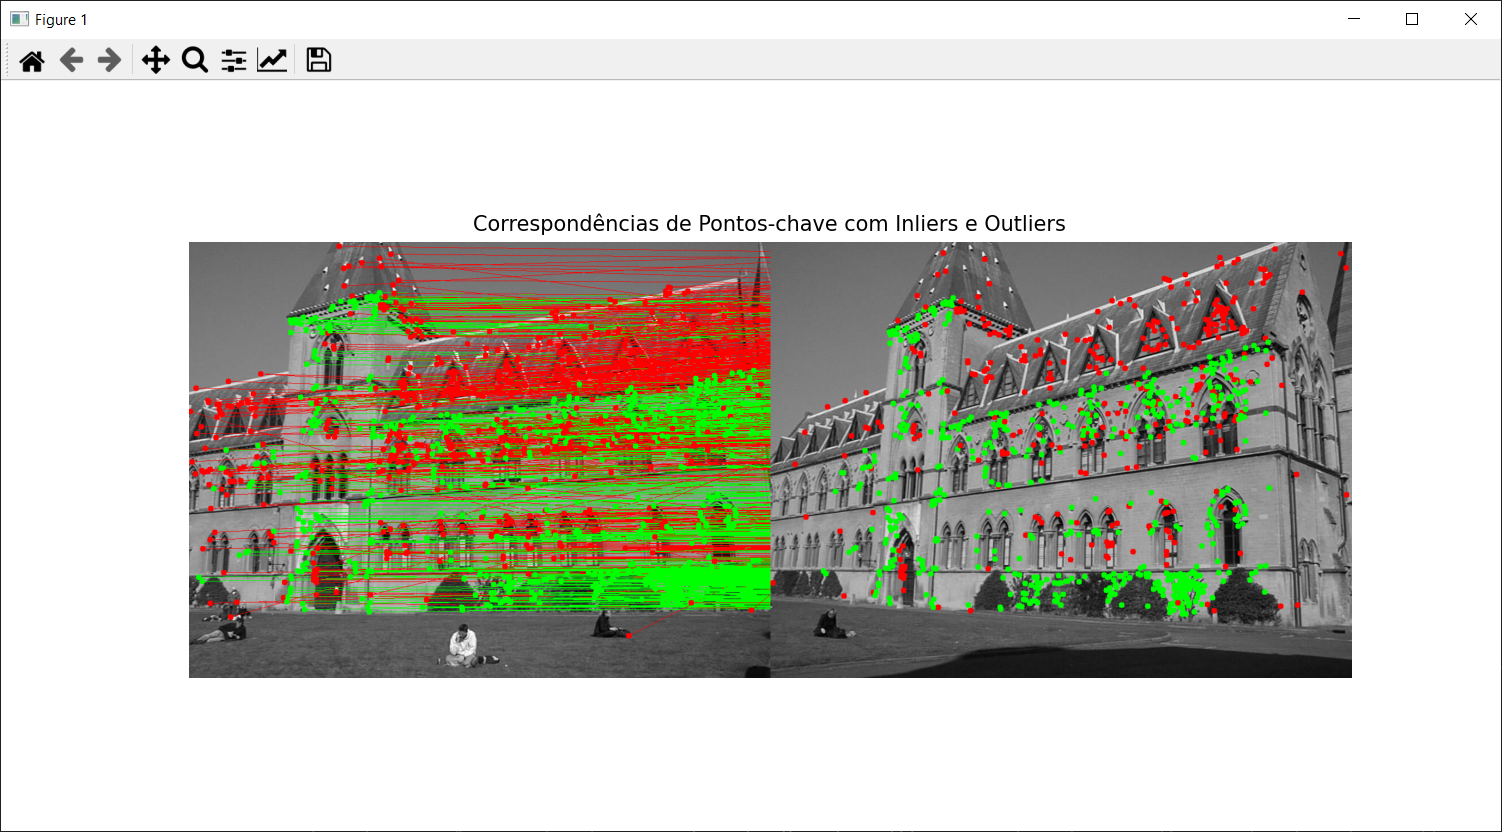